<a href="https://colab.research.google.com/github/PCSchmidt/My-Projects/blob/main/ConvolutionalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a Convolutional Autoencoder for Image Denoising

This is based on a keras.io tutorial authored by Santiago Valdarrama that builds a deep convolutional neural network autoencoder to denoise image files and map noisy digits from the MNIST dataset to clean image of the digits. Santiago's tutorial, in turn, followed a blog post by Francois Chollet , [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)


## Create the Initial Setup

In [2]:
# Import the libraries and modules needed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


In [3]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()



## Prepare the Data

11493376/11490434 [==============================] - 0s 0us/step


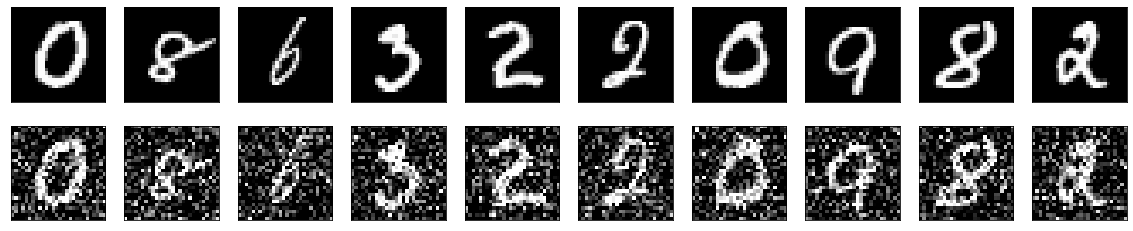

In [4]:
# For this project we only need images from the dataset to encode and decode so we do not need the labels.

(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with the added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with the added noise
display(train_data, noisy_train_data)

## Build the Autoencoder

We are going to use the Functional API to build the autoencoder.

In [5]:
input =layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

Now the autoencoder can be trained using `train_data` as both the input data and the target. We set up the validation data using the same format. 

In [6]:
 autoencoder.fit(
     x=train_data,
     y=train_data,
     epochs=50, 
     batch_size=128,
     shuffle=True,
     validation_data=(test_data, test_data)
 )

Epoch 1/50
469/469 [==============================] - 36s 9ms/step - loss: 0.1385 - val_loss: 0.0730
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0716 - val_loss: 0.0695
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0692 - val_loss: 0.0679
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0680 - val_loss: 0.0670
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0672 - val_loss: 0.0664
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0666 - val_loss: 0.0659
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0659 - val_loss: 0.0652
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0653 - val_loss: 0.064

Let's predict on our test dataset and display the original image together with the prediction from our outoencoder. Notice how the images are pretty close to the original images, although not quite the same. 

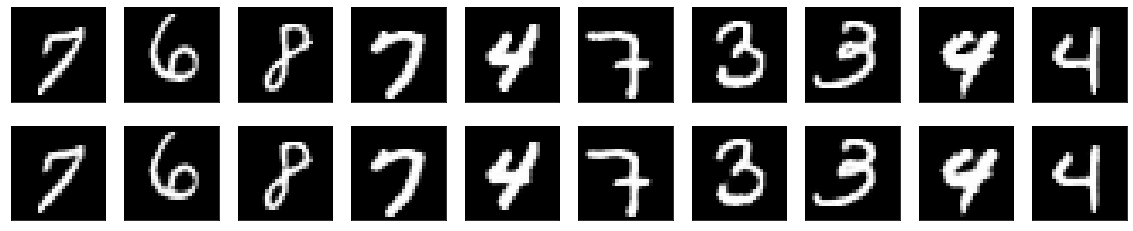

In [8]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know how our autoencoder works, let's retrain it using the noisy data as out input and the clean data as the target. We want the autoencoder to learn how to denoise the images. 

In [10]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data, 
    epochs=100, 
    batch_size=128, 
    shuffle=True,
    validation_data=(noisy_test_data, test_data)
)

Epoch 1/100
469/469 [==============================] - 4s 9ms/step - loss: 0.1003 - val_loss: 0.0933
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0928 - val_loss: 0.0910
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0911 - val_loss: 0.0898
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0901 - val_loss: 0.0891
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0894 - val_loss: 0.0885
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0888 - val_loss: 0.0882
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0884 - val_loss: 0.0877
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0881 - val_loss: 0.0874
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0878 - val_loss: 0.0871
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0875 - val_lo

Now let's predict on the noisy data and display the results of the autoencoder.
Notice how the autencoder does a great job at removing the noise from the input images.

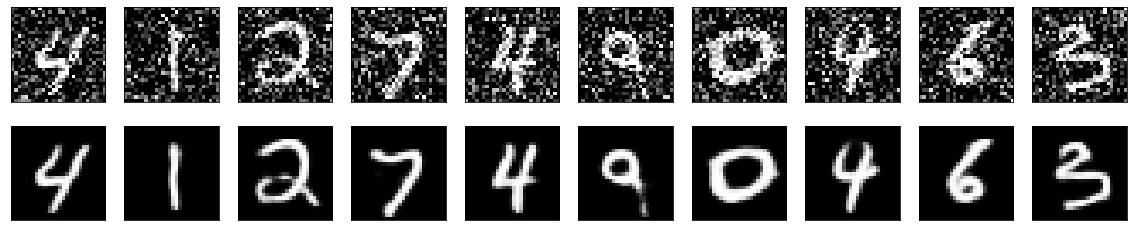

In [11]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)